# Convert Sigmet files into Zarr

## Imports

In [1]:
import cmweather  # noqa: F401
import fsspec
import xarray as xr

from raw2zarr.builder.builder_utils import get_icechunk_repo
from raw2zarr.builder.executor import append_sequential

Now let's convert some sigmet files hosted in the [IDEAM](https://registry.opendata.aws/ideam-radares/) AWS bucket.

In [2]:
radar = "Guaviare"
append_dim = "vcp_time"
engine = "iris"
zarr_format = 3
consolidated = True if zarr_format == 2 else False
zarr_store = f"../zarr/{radar}.zarr"
query = f"2025/09/05/{radar}/{radar[:3].upper()}"
str_bucket = "s3://s3-radaresideam/l2_data"

In [3]:
f"../zarr/{radar}.zarr"

'../zarr/Guaviare.zarr'

In [4]:
f"{str_bucket}{query}*"

's3://s3-radaresideam/l2_data2025/09/05/Guaviare/GUA*'

In [5]:
fs = fsspec.filesystem("s3", anon=True)
radar_files = [f"s3://{i}" for i in sorted(fs.glob(f"{str_bucket}/{query}*"))]

In [6]:
len(radar_files)

439

In [7]:
# ?append_files

In [8]:
test_files = radar_files[300:400]
print(f"Processing {len(test_files)} files for demonstration")

Processing 100 files for demonstration


In [9]:
# Initialize icechunk repository
repo = get_icechunk_repo(zarr_store)

  2025-09-21T12:34:14.095945Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



In [10]:
%%time
append_sequential(
    radar_files=test_files,
    append_dim=append_dim,
    repo=repo,
    zarr_format=zarr_format,
    engine=engine,
)

[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905045422.RAWU9BC as snapshot 632YNPDAPD6M4B0XES3G
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905045525.RAWU9BK as snapshot 21NVRY9JXRTMH5GFDJ4G
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905045630.RAWU9BW as snapshot W364AW4X59B84S9ZJGN0
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905045802.RAWU9BZ as snapshot 0K5E67FT6936RZYRFTGG
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905045840.RAWU9C3 as snapshot B85WHP3MVRRDKKZ9KP5G
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905045916.RAWU9C8 as snapshot TTZV4A584B6Q7GP0CY90
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905050018.RAWU9CH as snapshot J5106EC823TAQ1Z5PSPG
[icechunk] Committed s3://s3-radaresideam/l2_data/2025/09/05/Guaviare/GUA250905050122.RAWU9CV as snapshot 7KH21

## Read the radar datatree store in Zarr format

Create a readonly session to access the data.

In [11]:
session = repo.readonly_session("main")

Open the radar datatree using `xarray`.

In [12]:
%%time
dtree = xr.open_datatree(
    session.store,
    engine="zarr",
    zarr_format=3,
    consolidated=False,
    chunks={},
)

CPU times: user 698 ms, sys: 106 ms, total: 804 ms
Wall time: 808 ms


Explore the Guaviare `Datatree`

In [13]:
list(dtree.children)

['SURVP', 'PRECA', 'PRECC', 'PRECB']

Get available sweeps for `PRECA`

In [14]:
available_sweeps = [
    child for child in dtree["PRECA"].children if child.startswith("sweep_")
]
available_sweeps.sort(key=lambda x: int(x.split("_")[1]))  # Sort by sweep number

available_sweeps

['sweep_0', 'sweep_1', 'sweep_2', 'sweep_3']

Access the lower elevation angle for `PRECA`

In [15]:
ds_lower = dtree["PRECA/sweep_0"]

In [16]:
ds_lower

<xarray.DataTree 'sweep_0'>
Group: /PRECA/sweep_0
    Dimensions:            (vcp_time: 21, azimuth: 360, range: 747)
    Coordinates:
        altitude           float64 8B ...
        crs_wkt            int64 8B ...
        latitude           float64 8B ...
        elevation          (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        x                  (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
        z                  (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
      * range              (range) float32 3kB 2.125e+03 2.375e+03 ... 1.886e+05
        longitude          float64 8B ...
        y                  (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
    Inherited coordinates:
      * vcp_time           (vcp_time) datetime64[ns] 168B 2025-09-05T00:01:12 ......
    Data variables: (12/15)
        DBZH               (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        DBTH               (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        DB_DBZE8           (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        DB_HCLASS          (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        SQIH               (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        PHIDP              (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        ...                 ...
        ZDR                (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        RHOHV              (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        WRADH              (vcp_time, azimuth, range) float32 23MB dask.array<chunksize=(1, 360, 747), meta=np.ndarray>
        sweep_fixed_angle  (vcp_time) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>
        time               (azimuth) datetime64[ns] 3kB dask.array<chunksize=(360,), meta=np.ndarray>
        sweep_number       (vcp_time) float32 84B dask.array<chunksize=(1,), meta=np.ndarray>

Explore data variables

In [17]:
list(ds_lower.data_vars)

['DBZH',
 'DBTH',
 'DB_DBZE8',
 'DB_HCLASS',
 'SQIH',
 'PHIDP',
 'KDP',
 'DB_DBTE8',
 'VRADH',
 'ZDR',
 'RHOHV',
 'WRADH',
 'sweep_fixed_angle',
 'time',
 'sweep_number']

### Compute QPE

Lets compute the QPE using the Marshall and Gunn relationship

In [18]:
def rain_depth(
    z: xr.DataArray, a: float = 200.0, b: float = 1.6, t: float = None
) -> xr.DataArray:
    """
    Estimates rainfall depth using radar reflectivity and Z-R relationship.

    Parameters:
    -----------
    z : xr.DataArray
        Radar reflectivity in dBZ with vcp_time dimension.
    a : float, optional
        Z-R relationship parameter (default: 200.0, Marshall-Palmer 1948).
    b : float, optional
        Z-R relationship parameter (default: 1.6, Marshall-Palmer 1948).
    t : float, optional
        Integration time in minutes. If None, computed from vcp_time dimension.

    Returns:
    --------
    xr.DataArray
        Estimated rainfall depth (mm).
    """
    # Check for vcp_time dimension and compute integration time if not provided
    if t is None:
        if "vcp_time" not in z.dims:
            raise ValueError(
                "DataArray must have 'vcp_time' dimension or provide integration time 't'"
            )

        # Compute time differences in minutes
        time_diffs = z.vcp_time.diff("vcp_time")
        integration_time = time_diffs.dt.total_seconds() / 60.0  # Convert to minutes

        # Use the median time difference as representative integration time
        t = float(integration_time.median().values)
        actual_total_minutes = float(integration_time.sum().values)
        actual_total_seconds = actual_total_minutes * 60

        # Convert to days, hours, minutes
        total_days = int(actual_total_seconds // 86400)
        remaining_seconds = actual_total_seconds % 86400
        total_hours = int(remaining_seconds // 3600)
        remaining_seconds = remaining_seconds % 3600
        total_minutes = int(remaining_seconds // 60)

        print(
            f"Actual QPE integration period: {total_days} days, {total_hours} hours, {total_minutes} minutes"
        )
        print(
            f"Time span: {str(z.vcp_time.min().values)[:19]} to {str(z.vcp_time.max().values)[:19]} UTC"
        )

    # Convert reflectivity from dBZ to linear units
    z_lin = 10 ** (z / 10)

    # Compute rainfall depth using Z-R relationship and time integration
    depth = ((1 / a) ** (1 / b) * z_lin ** (1 / b)) * (t / 60)

    # Create new DataArray with proper name and attributes
    result = depth.copy()
    result.name = "rain_depth"
    result.attrs = {
        "units": "mm",
        "long_name": "rainfall depth",
        "standard_name": "rainfall_depth",
        "description": f"Estimated rainfall depth using Z-R relationship (a={a}, b={b})",
    }

    return result

In [19]:
%%time
qpe = rain_depth(dtree["PRECA/sweep_0/DBZH"])

Actual QPE integration period: 0 days, 6 hours, 30 minutes
Time span: 2025-09-05T00:01:12 to 2025-09-05T06:31:23 UTC
CPU times: user 8.77 ms, sys: 0 ns, total: 8.77 ms
Wall time: 8.62 ms


In [20]:
qpe

<xarray.DataArray 'rain_depth' (vcp_time: 21, azimuth: 360, range: 747)> Size: 23MB
dask.array<mul, shape=(21, 360, 747), dtype=float32, chunksize=(1, 360, 747), chunktype=numpy.ndarray>
Coordinates:
  * vcp_time   (vcp_time) datetime64[ns] 168B 2025-09-05T00:01:12 ... 2025-09...
    altitude   float64 8B ...
    crs_wkt    int64 8B ...
    latitude   float64 8B ...
    elevation  (azimuth) float64 3kB dask.array<chunksize=(360,), meta=np.ndarray>
  * azimuth    (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    x          (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
    z          (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
  * range      (range) float32 3kB 2.125e+03 2.375e+03 ... 1.884e+05 1.886e+05
    longitude  float64 8B ...
    y          (azimuth, range) float64 2MB dask.array<chunksize=(90, 374), meta=np.ndarray>
Attributes:
    units:          mm
    long_name:      rainfall depth
    standard_name:  rainfall_depth
    description:    Estimated rainfall depth using Z-R relationship (a=200.0,...

In [21]:
qpe_sum = qpe.sum("vcp_time")

Finally, we can create a ~1 hour QPE plot as follows:

CPU times: user 464 ms, sys: 51.7 ms, total: 515 ms
Wall time: 213 ms


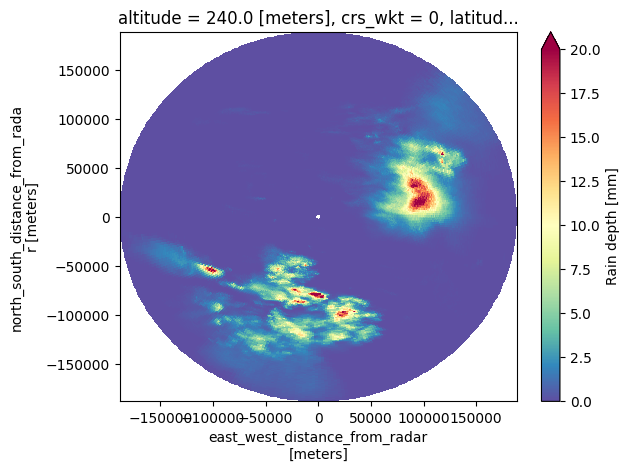

In [22]:
%%time
qpe_sum.plot(
    x="x",
    y="y",
    vmin=0,
    vmax=20,
    robust=True,
    cmap="Spectral_r",
    cbar_kwargs={"label": "Rain depth [mm]"},
)